In [3]:
import os
import sys
sys.path.append(os.path.abspath("../"))

import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plot_automations as plotter
from scipy.stats import entropy
import utils

In [4]:
artworks_df = pd.read_csv('../00_preprocessing/omniart-post-color-clustering.csv')

In [5]:
artworks_df

,artwork_name,artist_full_name,creation_year,decade,century,school,palette_count,colors_hex
0,70 amx,xynphix,2007.0,2000,21.0,modern,"[4009, 7637, 3303, 6147, 4742, 3908, 7216, 514...","['#e2ede4', '#969b91', '#6eccb0', '#2c4945', '..."
1,crucifixion (detail),andrea da firenze,1366.0,1360,14.0,Italy,"[6226, 6056, 4293, 6101, 5185, 5292, 6392, 384...","['#947b67', '#7a6351', '#82543d', '#625449', '..."
2,faith,giuseppe angeli,1754.0,1750,18.0,Italy,"[1007, 4537, 4708, 4466, 4432, 2946, 4776, 448...","['#000707', '#9d774c', '#965a36', '#180f0a', '..."
3,lamp post,williamsnape,2010.0,2010,21.0,modern,"[4225, 4308, 4914, 6274, 6911, 6261, 6753, 421...","['#c5aca3', '#967365', '#4c3830', '#402927', '..."
4,the one that got away,katiehofgard,2009.0,2000,21.0,modern,"[43399, 1136, 407, 2637, 2812, 679, 3585, 2514...","['#fefefe', '#fefefe', '#edf6f3', '#987658', '..."
...,...,...,...,...,...,...,...,...
264213,truth,circlekeeper,2008.0,2000,21.0,modern,"[1312, 5526, 9605, 9971, 4030, 5524, 5562, 286...","['#9f6b61', '#908d71', '#3e2e32', '#191719', '..."
264214,yavanna queen of the earth giver of fruits-tif...,tiffany-illustration,2017.0,2010,21.0,modern,"[15056, 255, 5087, 6846, 9838, 1577, 4027, 476...","['#fefefe', '#f5f9f9', '#dfe1d4', '#c3b49d', '..."
264215,unknown,kano furunobu,1700.0,1700,18.0,Japan,"[3431, 5740, 4247, 4971, 6362, 6885, 5328, 445...","['#afa691', '#a8906e', '#a8906e', '#9d8f72', '..."
264216,unknown,wang yuanqi,1715.0,1710,18.0,China,"[6512, 6102, 860, 6846, 4826, 5036, 5117, 3297...","['#f5f0e9', '#f7f2ee', '#efe1cf', '#f2d9bc', '..."


In [6]:
colors_df = pd.read_csv('../00_preprocessing/color-centroids.csv')

In [7]:
# Create a lookup dictionary for color properties from the colors dataframe
# This will make it fast to retrieve HSB values for a given HEX code.
color_lookup = colors_df.set_index('HEX').to_dict('index')

**1. Features**

In [8]:
def create_artwork_vector(row, color_map):
    palette_vector = []
    hex_list = row["colors_hex"]
    count_list = row["palette_count"]
    if isinstance(hex_list, str): hex_list = ast.literal_eval(hex_list)
    if isinstance(count_list, str): count_list = ast.literal_eval(count_list)
    for hex_code, count in zip(hex_list, count_list):
        color_info = color_map[hex_code]
        palette_vector.extend([color_info['H_sin'], color_info['H_cos'], color_info['S'], color_info['B'], count])
    return np.array(palette_vector)    

In [9]:
feature_vectors = artworks_df.apply(lambda row: create_artwork_vector(row, color_lookup), axis=1)

In [10]:
X = np.array(feature_vectors.tolist())

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**2. Clustering**

In [12]:
unique_decades = artworks_df["decade"].nunique()
unique_schools = artworks_df["school"].nunique()
print(unique_decades, unique_schools)

134 49


In [13]:
K = 100 # 1000 (total colors) / 10 (colors per artwork)

In [14]:
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)

In [15]:
artworks_df['cluster'] = kmeans.fit_predict(X_scaled)

In [16]:
artworks_df

,artwork_name,artist_full_name,creation_year,decade,century,school,palette_count,colors_hex,cluster
0,70 amx,xynphix,2007.0,2000,21.0,modern,"[4009, 7637, 3303, 6147, 4742, 3908, 7216, 514...","['#e2ede4', '#969b91', '#6eccb0', '#2c4945', '...",36
1,crucifixion (detail),andrea da firenze,1366.0,1360,14.0,Italy,"[6226, 6056, 4293, 6101, 5185, 5292, 6392, 384...","['#947b67', '#7a6351', '#82543d', '#625449', '...",81
2,faith,giuseppe angeli,1754.0,1750,18.0,Italy,"[1007, 4537, 4708, 4466, 4432, 2946, 4776, 448...","['#000707', '#9d774c', '#965a36', '#180f0a', '...",33
3,lamp post,williamsnape,2010.0,2010,21.0,modern,"[4225, 4308, 4914, 6274, 6911, 6261, 6753, 421...","['#c5aca3', '#967365', '#4c3830', '#402927', '...",24
4,the one that got away,katiehofgard,2009.0,2000,21.0,modern,"[43399, 1136, 407, 2637, 2812, 679, 3585, 2514...","['#fefefe', '#fefefe', '#edf6f3', '#987658', '...",76
...,...,...,...,...,...,...,...,...,...
264213,truth,circlekeeper,2008.0,2000,21.0,modern,"[1312, 5526, 9605, 9971, 4030, 5524, 5562, 286...","['#9f6b61', '#908d71', '#3e2e32', '#191719', '...",42
264214,yavanna queen of the earth giver of fruits-tif...,tiffany-illustration,2017.0,2010,21.0,modern,"[15056, 255, 5087, 6846, 9838, 1577, 4027, 476...","['#fefefe', '#f5f9f9', '#dfe1d4', '#c3b49d', '...",98
264215,unknown,kano furunobu,1700.0,1700,18.0,Japan,"[3431, 5740, 4247, 4971, 6362, 6885, 5328, 445...","['#afa691', '#a8906e', '#a8906e', '#9d8f72', '...",48
264216,unknown,wang yuanqi,1715.0,1710,18.0,China,"[6512, 6102, 860, 6846, 4826, 5036, 5117, 3297...","['#f5f0e9', '#f7f2ee', '#efe1cf', '#f2d9bc', '...",66


In [17]:
artworks_df.drop(['palette_count', 'colors_hex'], axis=1, inplace=True)

In [18]:
artworks_df['cluster'].value_counts().median()

2457.0

In [19]:
artworks_df.to_csv('omniart-post-artwork-clustering.csv', index=False)

In [20]:
cluster_centers_scaled = kmeans.cluster_centers_
cluster_centers_unscaled = scaler.inverse_transform(cluster_centers_scaled)

In [21]:
export_column_names = []
for n in range(0, 10):
    export_column_names.extend([f"{n}_H_sin", f"{n}_H_cos", f"{n}_S", f"{n}_B", f"{n}_weight"])

In [22]:
centroids_df = pd.DataFrame(cluster_centers_unscaled, columns=export_column_names)

In [23]:
centroids_df.insert(0, 'name', [f"cluster_{i}" for i in range(K)])

In [24]:
centroids_df

,name,0_H_sin,0_H_cos,0_S,0_B,0_weight,1_H_sin,1_H_cos,1_S,1_B,...,8_H_sin,8_H_cos,8_S,8_B,8_weight,9_H_sin,9_H_cos,9_S,9_B,9_weight
0,cluster_0,0.791800,0.133922,0.074961,0.899168,5030.074250,0.800998,0.141190,0.104510,0.839724,...,0.777080,0.099174,0.136409,0.749289,5312.406500,0.735421,0.047229,0.156489,0.689686,5385.966500
1,cluster_1,0.530026,0.782022,0.216750,0.773710,4793.158448,0.465574,0.804967,0.298091,0.625358,...,0.444518,0.815419,0.321504,0.551500,5200.348628,0.390817,0.804262,0.334045,0.423659,5366.864494
2,cluster_2,-0.166436,-0.552587,0.398104,0.757586,4817.653798,-0.312386,-0.678173,0.533404,0.648958,...,-0.373920,-0.736625,0.646117,0.584332,5098.820050,-0.407253,-0.748510,0.702623,0.549182,5269.719178
3,cluster_3,-0.100049,-0.694466,0.079017,0.826992,4684.306992,-0.240396,-0.823685,0.106344,0.738455,...,0.403223,0.457635,0.268262,0.484555,5223.102969,0.363924,0.413084,0.289920,0.430774,5353.674808
4,cluster_4,0.595687,0.739389,0.377727,0.861292,4295.849112,0.533391,0.790285,0.521619,0.764341,...,0.368858,0.818159,0.623441,0.415258,5758.216568,0.394392,0.813161,0.621872,0.459067,5304.243491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,cluster_95,0.428485,0.701518,0.105666,0.896500,5339.813055,0.308248,0.611336,0.148969,0.822445,...,0.181794,0.628237,0.184095,0.758793,5132.721137,-0.104048,0.457198,0.218095,0.642370,5227.182948
96,cluster_96,0.420525,0.502657,0.145562,0.809123,5201.455257,-0.004806,0.056007,0.220286,0.644355,...,-0.328049,-0.234671,0.260927,0.523656,5285.874328,-0.452689,-0.403373,0.330880,0.431495,5444.749144
97,cluster_97,0.104249,0.881920,0.040403,0.943068,5596.212470,0.117005,0.898931,0.060773,0.905503,...,0.075642,0.879162,0.090622,0.845089,5276.281775,0.040706,0.839970,0.101923,0.790031,5321.805036
98,cluster_98,0.066818,0.896799,0.012185,0.989258,10643.981775,0.041026,-0.714258,0.026356,0.962976,...,0.371582,0.481119,0.153822,0.838213,5474.464748,0.376930,0.426027,0.192283,0.774149,5789.429736


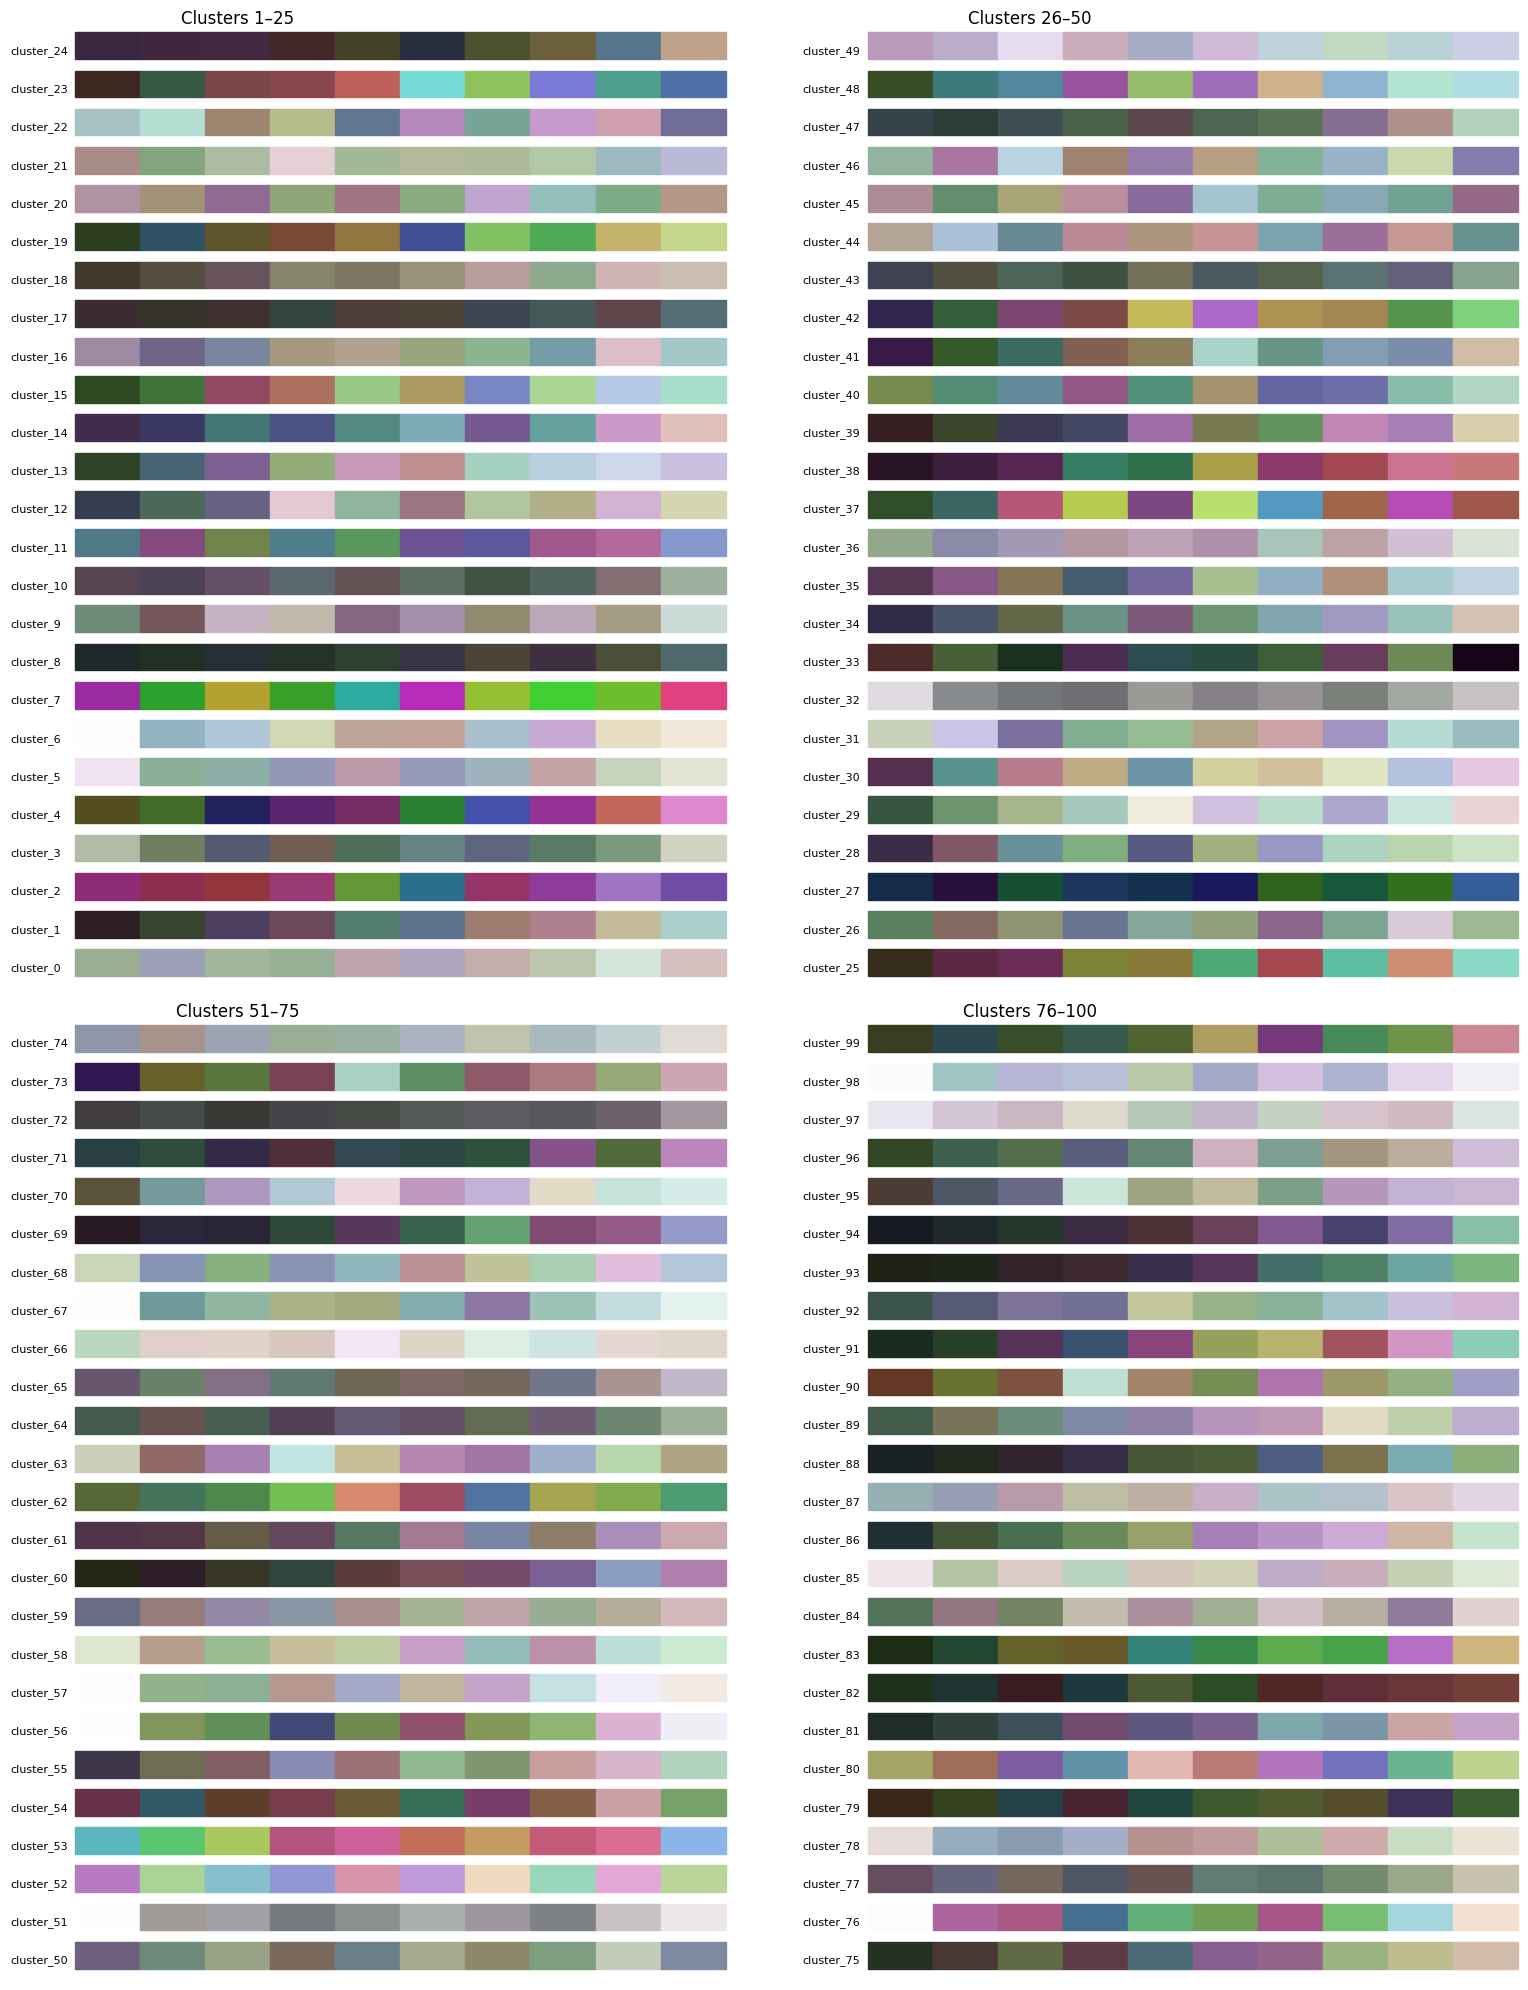

In [25]:
plotter.plot_artworks_clusters_centroids(centroids_df)

**3. Centroids information expansion**

In [26]:
def add_hue_columns(df):
    for i in range(10):
        sin_col = f'{i}_H_sin'
        cos_col = f'{i}_H_cos'
        hue_col = f'{i}_H'
        df[hue_col] = utils.sin_cos_to_hue(df[sin_col], df[cos_col])
    return df

In [27]:
def add_hsv_minmax(df):
    hue_matrix = np.array([df[f'{i}_H'] for i in range(10)]).T
    s_matrix = np.array([df[f'{i}_S'] for i in range(10)]).T
    b_matrix = np.array([df[f'{i}_B'] for i in range(10)]).T

    df['min_H'] = hue_matrix.min(axis=1)
    df['max_H'] = hue_matrix.max(axis=1)

    df['min_S'] = s_matrix.min(axis=1)
    df['max_S'] = s_matrix.max(axis=1)

    df['min_B'] = b_matrix.min(axis=1)
    df['max_B'] = b_matrix.max(axis=1)

    return df

In [28]:
def add_coverage_ratios(df):
    df['cov_H'] = (df['max_H'] - df['min_H']) / 360.0
    df['cov_S'] = (df['max_S'] - df['min_S']) / 1.0
    df['cov_B'] = (df['max_B'] - df['min_B']) / 1.0
    return df

In [29]:
def weighted_avg_and_std(values, weights):
    avg = np.average(values, weights=weights)
    variance = np.average((values - avg) ** 2, weights=weights)
    return avg, np.sqrt(variance)

In [30]:
def add_hsv_features(df):
    h_matrix = np.array([df[f'{i}_H'] for i in range(10)]).T
    s_matrix = np.array([df[f'{i}_S'] for i in range(10)]).T
    b_matrix = np.array([df[f'{i}_B'] for i in range(10)]).T
    w_matrix = np.array([df[f'{i}_weight'] for i in range(10)]).T

    avg_h, h_std, avg_s, s_std, avg_b, b_std = [],[],[],[],[],[]

    for i in range(len(df)):
        ah, hs = weighted_avg_and_std(h_matrix[i], w_matrix[i])
        avg_h.append(ah)
        h_std.append(hs)

        asat, ss = weighted_avg_and_std(s_matrix[i], w_matrix[i])
        avg_s.append(asat)
        s_std.append(ss)

        ab, bs = weighted_avg_and_std(b_matrix[i], w_matrix[i])
        avg_b.append(ab)
        b_std.append(bs)

    df['avg_H'] = avg_h
    df['var_H'] = h_std
    df['avg_S'] = avg_s
    df['var_S'] = s_std
    df['avg_B'] = avg_b
    df['var_B'] = b_std

    return df

In [31]:
centroids_df = add_hue_columns(centroids_df)

In [32]:
centroids_df = add_hsv_minmax(centroids_df)

In [33]:
centroids_df = add_coverage_ratios(centroids_df)

In [34]:
centroids_df = add_hsv_features(centroids_df)

In [35]:
centroids_df

,name,0_H_sin,0_H_cos,0_S,0_B,0_weight,1_H_sin,1_H_cos,1_S,1_B,...,max_B,cov_H,cov_S,cov_B,avg_H,homo_H,avg_S,homo_S,avg_B,homo_B
0,cluster_0,0.791800,0.133922,0.074961,0.899168,5030.074250,0.800998,0.141190,0.104510,0.839724,...,0.899168,0.017767,0.083970,0.216205,82.820502,2.208253,0.132623,0.023962,0.756522,0.063576
1,cluster_1,0.530026,0.782022,0.216750,0.773710,4793.158448,0.465574,0.804967,0.298091,0.625358,...,0.815958,0.059792,0.155433,0.636220,27.446157,5.865098,0.295313,0.048107,0.498541,0.202056
2,cluster_2,-0.166436,-0.552587,0.398104,0.757586,4817.653798,-0.312386,-0.678173,0.533404,0.648958,...,0.757586,0.032744,0.304519,0.208404,205.777170,3.053766,0.619984,0.084159,0.599972,0.057424
3,cluster_3,-0.100049,-0.694466,0.079017,0.826992,4684.306992,-0.240396,-0.823685,0.106344,0.738455,...,0.826992,0.430251,0.210903,0.396218,74.381538,58.364449,0.224520,0.068745,0.545504,0.124686
4,cluster_4,0.595687,0.739389,0.377727,0.861292,4295.849112,0.533391,0.790285,0.521619,0.764341,...,0.861292,0.043630,0.293609,0.537224,27.370478,4.528344,0.608574,0.079066,0.524245,0.164932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,cluster_95,0.428485,0.701518,0.105666,0.896500,5339.813055,0.308248,0.611336,0.148969,0.822445,...,0.896500,0.939911,0.199669,0.595502,168.414695,139.889843,0.202808,0.058032,0.635348,0.193080
96,cluster_96,0.420525,0.502657,0.145562,0.809123,5201.455257,-0.004806,0.056007,0.220286,0.644355,...,0.840281,0.877796,0.363153,0.567674,199.294310,106.001991,0.271846,0.110730,0.561131,0.180128
97,cluster_97,0.104249,0.881920,0.040403,0.943068,5596.212470,0.117005,0.898931,0.060773,0.905503,...,0.943068,0.012893,0.063903,0.159935,5.039568,1.292888,0.083279,0.018791,0.841077,0.049974
98,cluster_98,0.066818,0.896799,0.012185,0.989258,10643.981775,0.041026,-0.714258,0.026356,0.962976,...,0.989258,0.479032,0.180098,0.215109,36.495276,31.329887,0.123115,0.064460,0.862799,0.079904


In [36]:
centroids_df.to_csv('artwork-centroids.csv', index=False)

**4. Visualization**

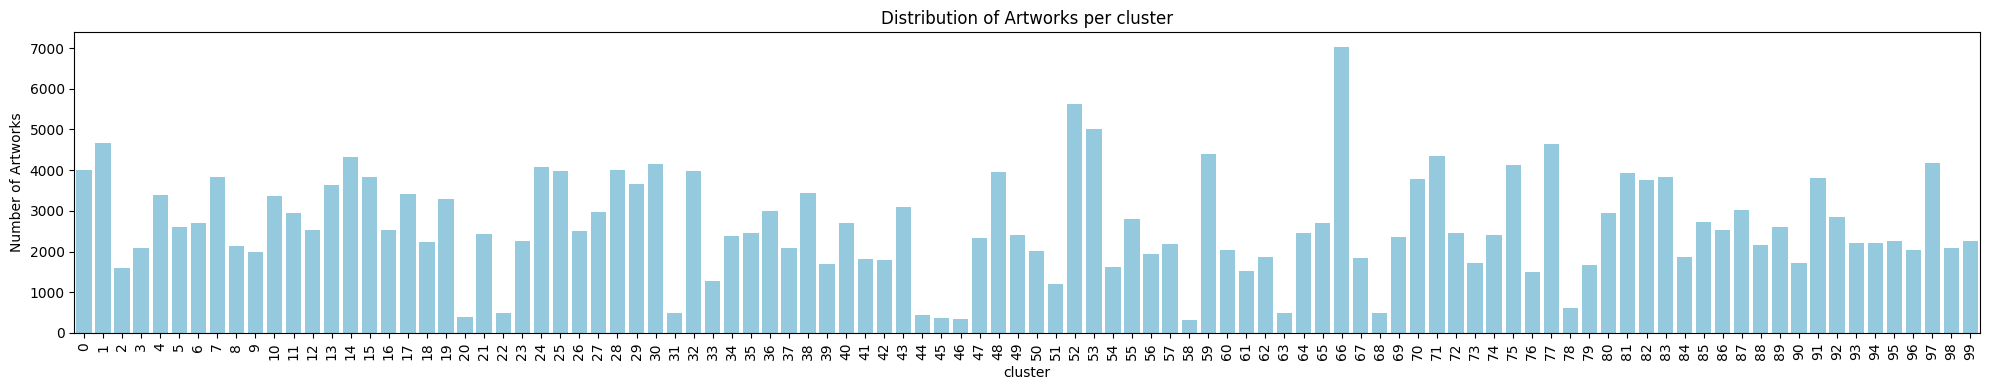

In [50]:
plotter.plot_artwork_distribution(artworks_df, "cluster")

**4.1 Hue**

In [68]:
H_monochromatic = 0.04          # 15 degrees
H_analogous = 0.16              # 60 degrees
H_triadic = 0.32                # 120 degrees
H_complimentary = 0.48          # 180 degrees

In [164]:
import matplotlib.pyplot as plt

def plot_H_coverage(df, col, mono_t, analog_t, triad_t):
    plt.figure(figsize=(20, 5))
    plt.bar(df['name'], df[col], color="skyblue")
    plt.axhline(y=mono_t, color='hotpink', linestyle='--', label=f'Monochromatic ({mono_t})')
    plt.axhline(y=analog_t, color='purple', linestyle='--', label=f'Analogous ({analog_t})')
    plt.axhline(y=triad_t, color='green', linestyle='--', label=f'Triadic/Complimentary ({triad_t})')
    plt.title(f"{col.replace('_', ' ').capitalize()} per Cluster")
    plt.ylabel("Fraction of Range Covered")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

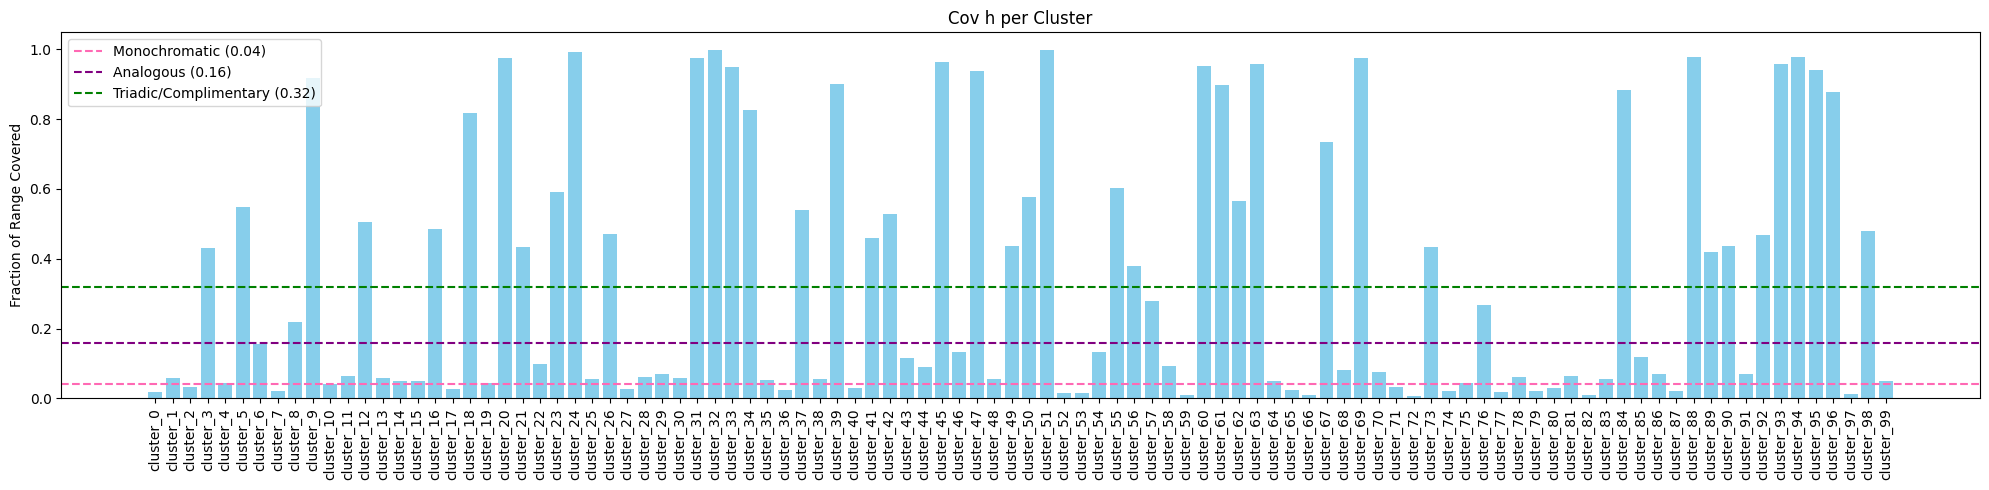

In [165]:
plot_H_coverage(centroids_df, "cov_H", H_monochromatic, H_analogous, H_triadic)

In [73]:
print(f"Monochromatic clusters: {(centroids_df['cov_H'] < H_monochromatic).sum()}")
print(f"Analogous clusters: {((centroids_df['cov_H'] > H_monochromatic) & (centroids_df['cov_H'] <= H_analogous)).sum()}")
print(f"Triadic clusters: {((centroids_df['cov_H'] > H_analogous) & (centroids_df['cov_H'] <= H_complimentary)).sum()}")
print(f"Complimentary clusters: {(centroids_df['cov_H'] > H_complimentary).sum()}")

Monochromatic clusters: 21
Analogous clusters: 33
Triadic clusters: 14
Complimentary clusters: 32


**4.2 Saturation**

In [59]:
homogeneity = 0.3

In [60]:
import matplotlib.pyplot as plt

def plot_coverage(df, col, homo_t):
    plt.figure(figsize=(20, 5))
    plt.bar(df['name'], df[col], color="skyblue")
    plt.axhline(y=homo_t, color='hotpink', linestyle='--', label=f'Homogeneous ({homo_t})')
    plt.title(f"{col.replace('_', ' ').capitalize()} per Cluster")
    plt.ylabel("Fraction of Range Covered")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

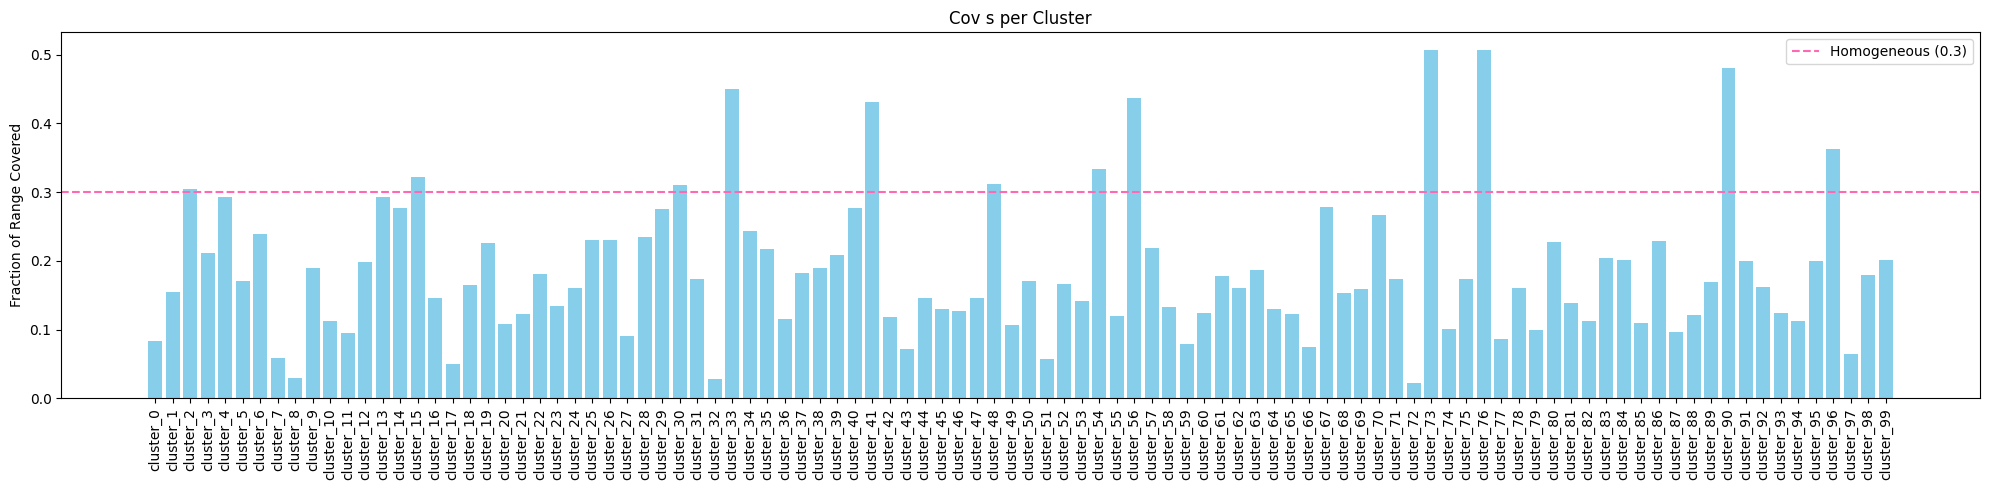

In [62]:
plot_coverage(centroids_df, "cov_S", homogeneity)

In [147]:
print(f"Homogeneously saturated clusters: {(centroids_df['cov_S'] <= homogeneity).sum()}")
print(f"Heterogeneously saturated clusters: {(centroids_df['cov_S'] > homogeneity).sum()}")

Homogeneously saturated clusters: 88
Heterogeneously saturated clusters: 12


In [109]:
muted = 0.4
gray = 0.15

In [106]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sats_stats(min_S, avg_S, max_S, muted=0.4, gray=0.15):
    clusters = np.arange(len(min_S))  # assuming all arrays have the same length

    plt.figure(figsize=(12, 6))

    plt.plot(clusters, min_S, label='Min Saturation', color='gray', linestyle='--')
    plt.plot(clusters, avg_S, label='Average Saturation', color='steelblue')
    plt.plot(clusters, max_S, label='Max Saturation', color='skyblue', linestyle='--')

    plt.axhline(y=gray, color='hotpink', linestyle=':', linewidth=1.5, label='Gray threshold')
    plt.axhline(y=muted, color='green', linestyle=':', linewidth=1.5, label='Muted/Saturated threshold')

    plt.xlabel('Cluster Index')
    plt.ylabel('Saturation')
    plt.title('Min, Avg, and Max Saturation per Cluster')

    plt.xticks(clusters[::5])  # Show every 5th cluster index for readability
    plt.yticks([i/10 for i in range(11)])
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

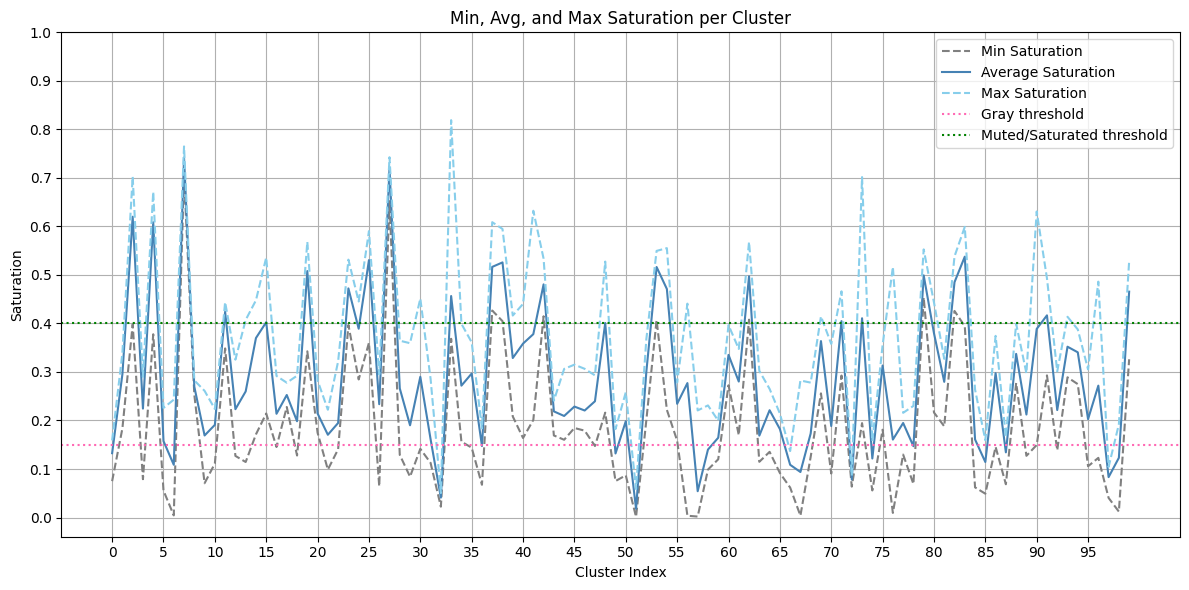

In [107]:
plot_sats_stats(centroids_df["min_S"], centroids_df["avg_S"], centroids_df["max_S"])

In [143]:
print(f"Clusters where average saturation is below muted: {(centroids_df['avg_S'] <= muted).sum()}")
print(f"Clusters where maximum saturation is below muted: {(centroids_df['max_S'] <= muted).sum()}")
print(f"Clusters where minimum saturation is over muted: {(centroids_df['min_S'] >= muted).sum()}")

Clusters where average saturation is below muted: 76
Clusters where maximum saturation is below muted: 62
Clusters where minimum saturation is over muted: 9


In [145]:
print(f"Clusters where average saturation is below gray: {(centroids_df['avg_S'] <= gray).sum()}")
print(f"Clusters where maximum saturation is below gray: {(centroids_df['max_S'] <= gray).sum()}")
print(f"Clusters where minimum saturation is over gray: {(centroids_df['min_S'] >= gray).sum()}")

Clusters where average saturation is below gray: 17
Clusters where maximum saturation is below gray: 5
Clusters where minimum saturation is over gray: 49


**4.3 Brightness**

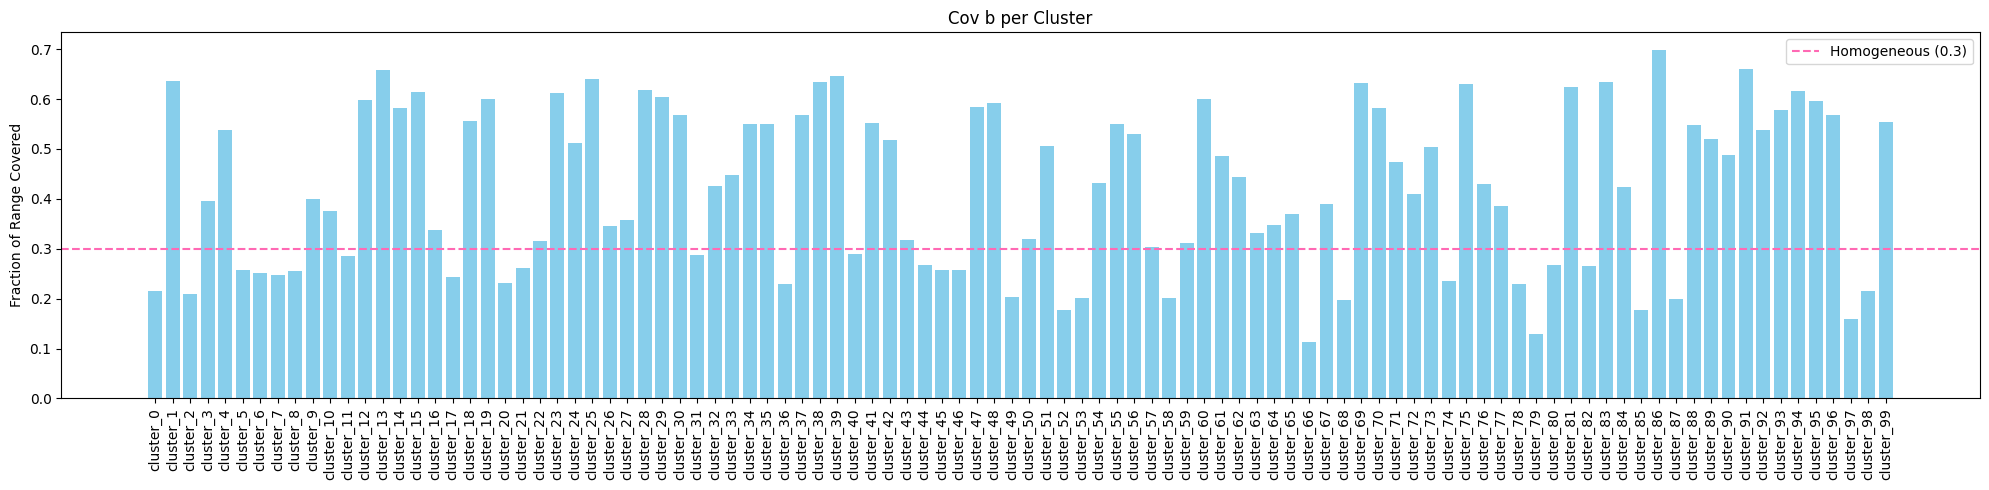

In [64]:
plot_coverage(centroids_df, "cov_B", homogeneity)

In [146]:
print(f"Homogeneously bright clusters: {(centroids_df['cov_B'] <= homogeneity).sum()}")
print(f"Heterogeneously bright clusters: {(centroids_df['cov_B'] > homogeneity).sum()}")

Homogeneously bright clusters: 31
Heterogeneously bright clusters: 69


In [125]:
white = 0.9
black = 0.1

light = 0.8
dark = 0.2

In [122]:
import matplotlib.pyplot as plt
import numpy as np

def plot_brig_stats(min_B, avg_B, max_B, black=0.1, white=0.9, light=0.8, dark=0.2):
    clusters = np.arange(len(min_B))  # assuming all arrays have the same length

    plt.figure(figsize=(12, 6))

    plt.plot(clusters, min_B, label='Min Brightness', color='gray', linestyle='--')
    plt.plot(clusters, avg_B, label='Average Brightness', color='steelblue')
    plt.plot(clusters, max_B, label='Max Brightness', color='skyblue', linestyle='--')
    plt.axhline(y=black, color='hotpink', linestyle=':', linewidth=1.5, label='Black threshold')
    plt.axhline(y=white, color='green', linestyle=':', linewidth=1.5, label='White threshold')
    plt.axhline(y=dark, color='purple', linestyle=':', linewidth=1.5, label='Dark threshold')
    plt.axhline(y=light, color='gold', linestyle=':', linewidth=1.5, label='Light threshold')

    plt.xlabel('Cluster Index')
    plt.ylabel('Brightness')
    plt.title('Min, Avg, and Max Brightness per Cluster')

    plt.xticks(clusters[::5])  # Show every 5th cluster index for readability
    plt.yticks([i/10 for i in range(11)])
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

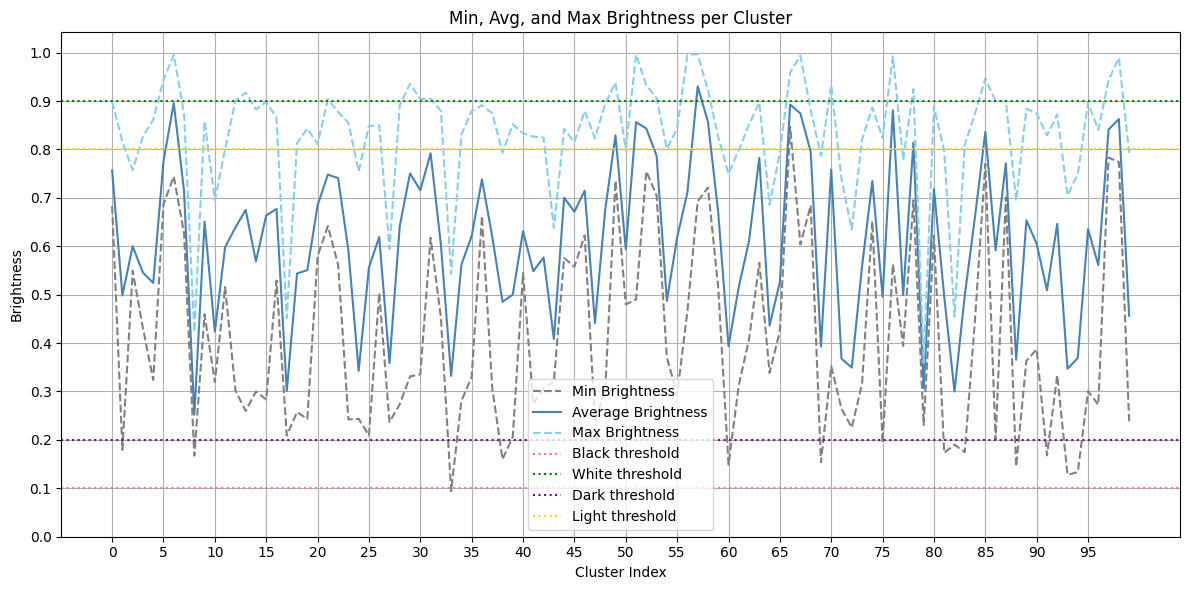

In [123]:
plot_brig_stats(centroids_df["min_B"], centroids_df["avg_B"], centroids_df["max_B"])

In [155]:
print(f"Clusters where average brightness is over black: {(centroids_df['avg_B'] >= black).sum()}")
print(f"Clusters where maximum brightness is over black: {(centroids_df['max_B'] >= black).sum()}")
print(f"Clusters where minimum brightness is below black: {(centroids_df['min_B'] <= black).sum()}")

Clusters where average brightness is over black: 100
Clusters where maximum brightness is over black: 100
Clusters where minimum brightness is below black: 1


In [154]:
print(f"Clusters where average brightness is over dark: {(centroids_df['avg_B'] >= dark).sum()}")
print(f"Clusters where maximum brightness is over dark: {(centroids_df['max_B'] >= dark).sum()}")
print(f"Clusters where minimum brightness is below dark: {(centroids_df['min_B'] <= dark).sum()}")

Clusters where average brightness is over dark: 100
Clusters where maximum brightness is over dark: 100
Clusters where minimum brightness is below dark: 14


In [160]:
print(f"Clusters where average brightness is below white: {(centroids_df['avg_B'] <= white).sum()}")
print(f"Clusters where maximum brightness is below white: {(centroids_df['max_B'] <= white).sum()}")
print(f"Clusters where minimum brightness is above white: {(centroids_df['min_B'] >= white).sum()}")

Clusters where average brightness is below white: 99
Clusters where maximum brightness is below white: 77
Clusters where minimum brightness is above white: 0


In [161]:
print(f"Clusters where average brightness is below light: {(centroids_df['avg_B'] <= light).sum()}")
print(f"Clusters where maximum brightness is below light: {(centroids_df['max_B'] <= light).sum()}")
print(f"Clusters where minimum brightness is above light: {(centroids_df['min_B'] >= light).sum()}")

Clusters where average brightness is below light: 87
Clusters where maximum brightness is below light: 25
Clusters where minimum brightness is above light: 1


**4.4. Relationship to decades**

In [ ]:
def plot_cluster_vs_dim(df, target_dim):
    # Crosstab data
    data = pd.crosstab(df['cluster'], df[target_dim])
    top = data.sum().sort_values(ascending=False).head(20).index
    data = data[top]

    # Normalize columns for consistent color mapping
    dim_colors = dict(zip(data.columns, sns.color_palette("tab20", n_colors=len(data.columns))))

    # Create main figure with two sections: bar plot + legend matrix
    fig = plt.figure(figsize=(16, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1], wspace=0.3)

    # === Stacked Bar Plot ===
    ax0 = plt.subplot(gs[0])
    bottom = pd.Series([0]*len(data), index=data.index)

    for school in data.columns:
        ax0.bar(data.index, data[school], bottom=bottom, label=school, color=dim_colors[school])
        bottom += data[school]

    ax0.set_title(f'{target_dim} prevalence in clusters')
    ax0.set_xlabel('Cluster')
    ax0.set_ylabel('Number of Artworks')
    ax0.tick_params(axis='x', rotation=90)

    # === Legend as Matrix ===
    ax1 = plt.subplot(gs[1])
    ax1.axis('off')

    # Build a matrix-style legend
    rows = len(data.columns)
    for i, school in enumerate(data.columns):
        ax1.add_patch(plt.Rectangle((0, rows - i - 1), 1, 1, color=dim_colors[school]))
        ax1.text(1.2, rows - i - 0.5, school, va='center', fontsize=9)

    ax1.set_xlim(0, 5)
    ax1.set_ylim(0, rows)
    ax1.set_title(f'Legend ({target_dim})', fontsize=12, pad=10)

    plt.tight_layout()
    plt.show()

/Users/mulan/Documents/Documents - Giulia’s MacBook Air/UFMG/MINERACAO/project/art_data_mining/plot_automations.py:225: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


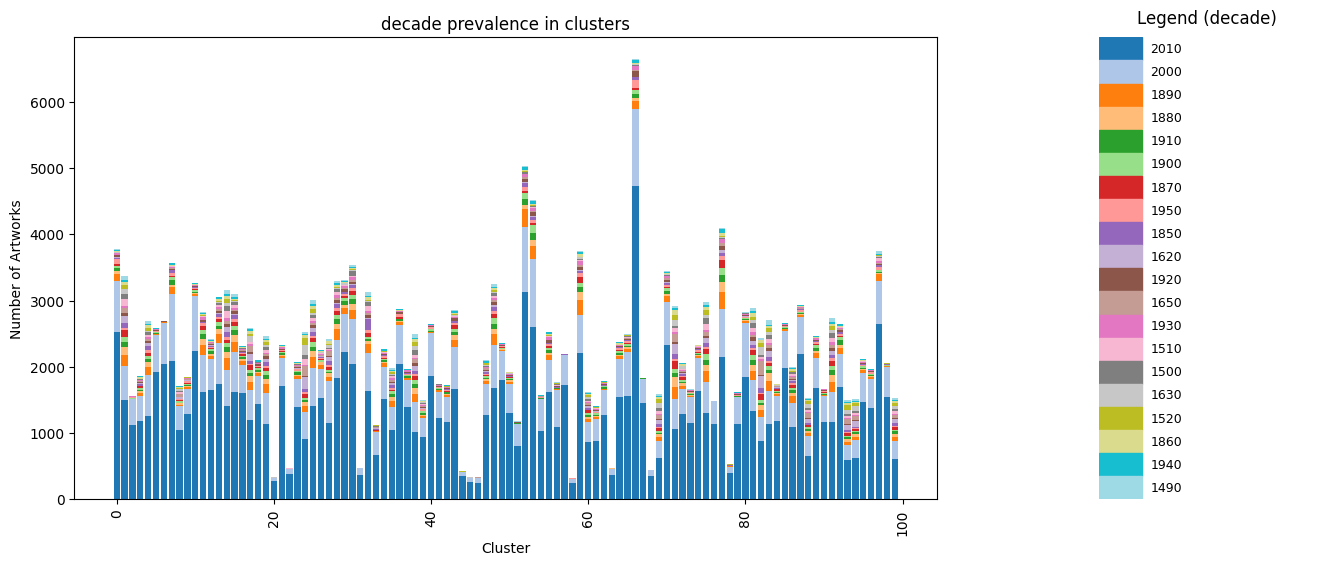

In [112]:
plot_cluster_vs_dim(artworks_df, "decade")

In [ ]:
def plot_entropy(df, target_dim="decade"):
    def shannon_entropy(s):
        return entropy(s.value_counts(normalize=True))

    # Compute entropy per cluster
    entropy_per_cluster = df.groupby('cluster')[target_dim].apply(shannon_entropy)

    # Plot with improved formatting
    plt.figure(figsize=(16, 6))  # Wider figure
    entropy_per_cluster.plot(kind='bar', color='skyblue')
    plt.title(f"{target_dim} diversity (entropy) per artwork cluster")
    plt.ylabel("Shannon Entropy")
    plt.xlabel("Cluster")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

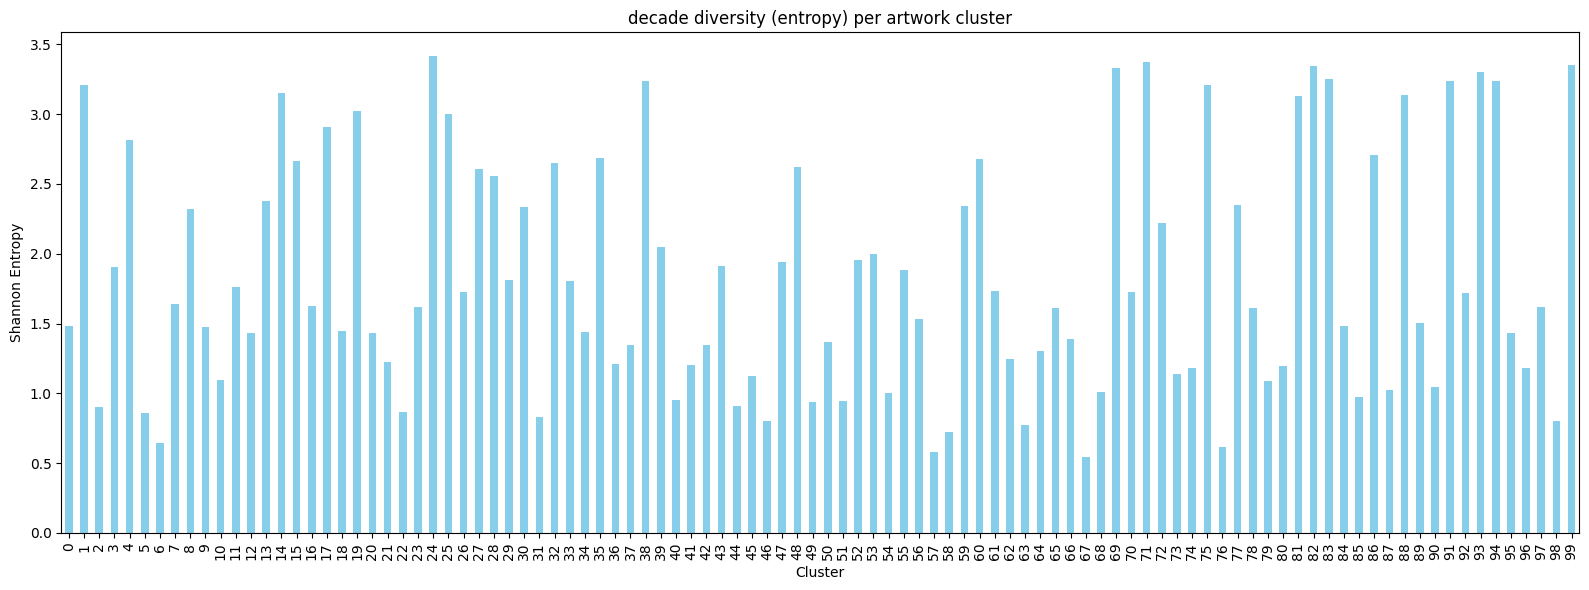

In [ ]:
plot_entropy(artworks_df, "decade")

/Users/mulan/Documents/Documents - Giulia’s MacBook Air/UFMG/MINERACAO/project/art_data_mining/plot_automations.py:225: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


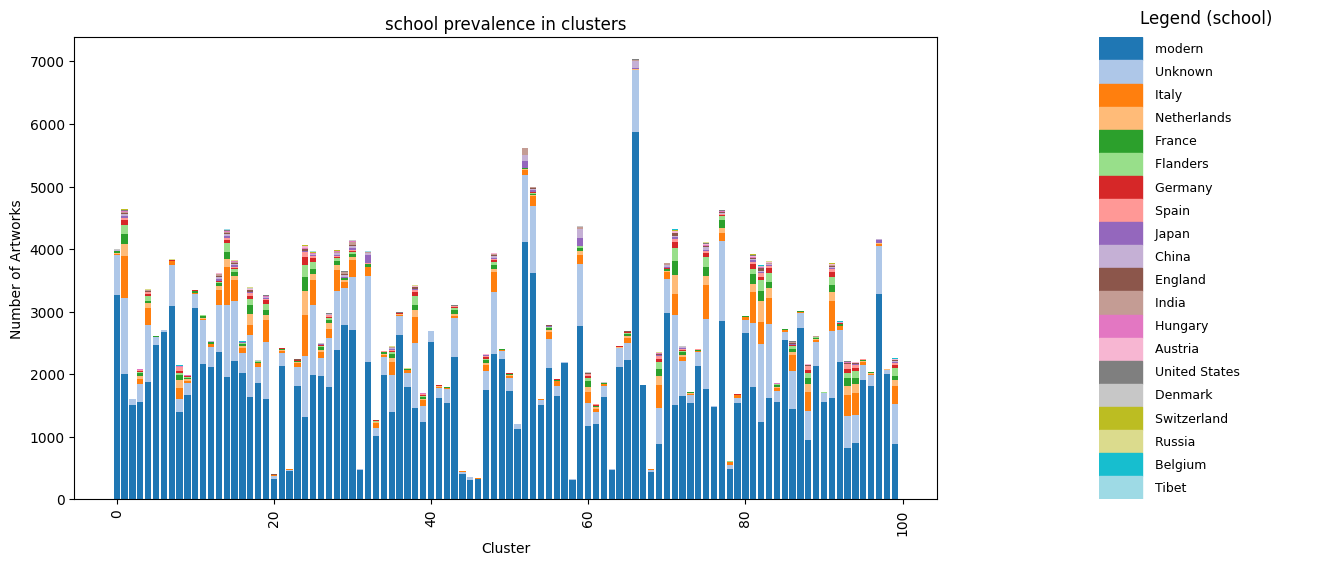

In [ ]:
plotter.plot_cluster_vs_dim(artworks_df, "school")

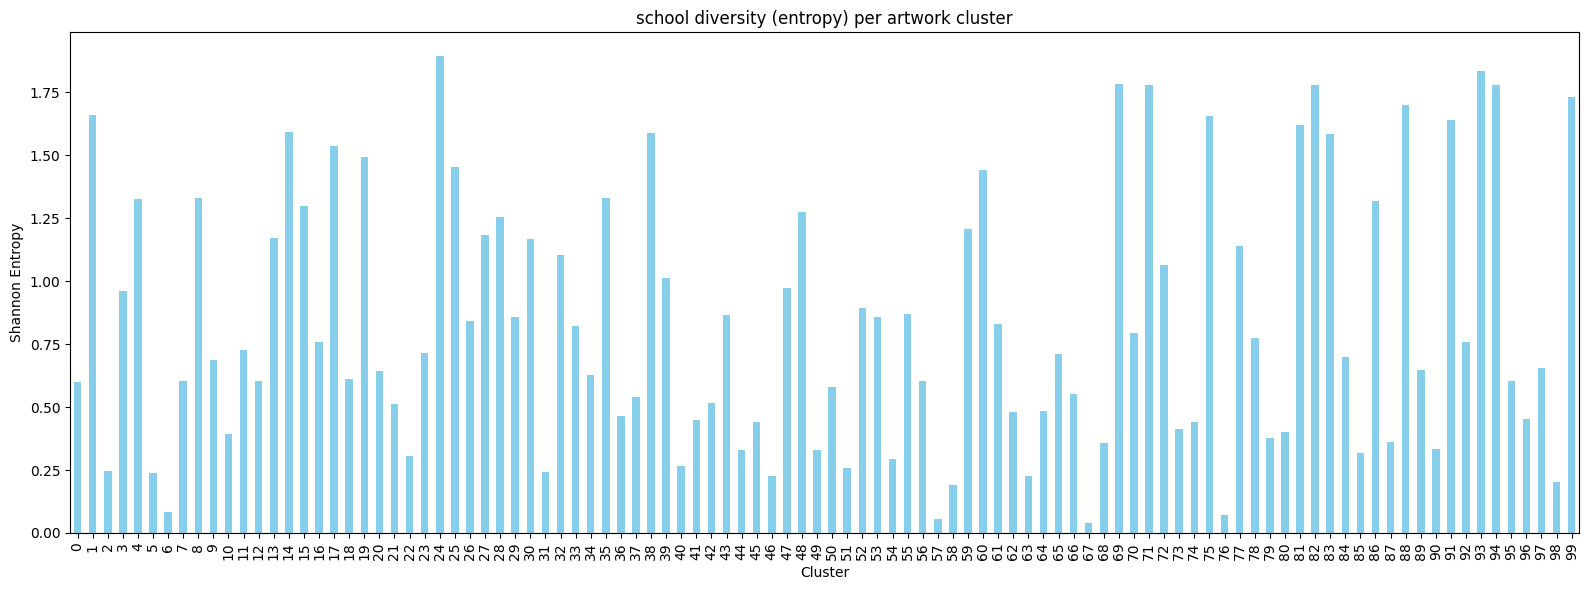

In [ ]:
plotter.plot_entropy(artworks_df, "school")